# Example 5: Generic cell signaling system in 3D

Geometry is divided into 4 domains; two volumes, and two surfaces:
- cytosol (Cyto): $\Omega_{Cyto}$
- endoplasmic reticulum volume (ER): $\Omega_{ER}$
- plasma membrane (PM): $\Gamma_{PM}$
- ER membrane (ERm): $\Gamma_{ERm}$

For simplicity, here we consider a "cube-within-a-cube" geometry, in which the smaller
inner cube represents a section of ER and one face of the outer cube ($x=0$) represents the PM. The other
faces of the outer cube are treated as no flux boundaries. The space outside
the inner cube but inside the outer cube is classified as cytosol.

There are three function-spaces on these three domains:

$$
u^{Cyto} = [A, B] \quad \text{on} \quad \Omega^{Cyto}\\
u^{ER} = [AER] \quad \text{on} \quad \Omega^{ER}\\
v^{ERm} = [R, Ro] \quad \text{on} \quad \Gamma^{ERm}
$$

In words, this says that species A and B reside in the cytosolic volume, 
species AER corresponds to an amount of species A that lives in the ER volume,
and species R (closed receptor/channel) and Ro (open receptor/channel) reside on the ER membrane.

In this model, species B reacts with a receptor/channel, R, on the ER membrane, causing it to open (change state from R->Ro), 
allowing species A to flow out of the ER and into the cytosol. 
Note that this is roughly similar to an IP<sub>3</sub> pulse at the PM, leading to Ca<sup>2+</sup> release from the ER,
where, by analogy, species B is similar to IP<sub>3</sub> and species A is similar to Ca<sup>2+</sup>. A more comprehensive
model of Ca<sup>2+</sup> dynamics in particular is implemented in Example 6.


(-0.5, 2880.5, 2782.5, -0.5)

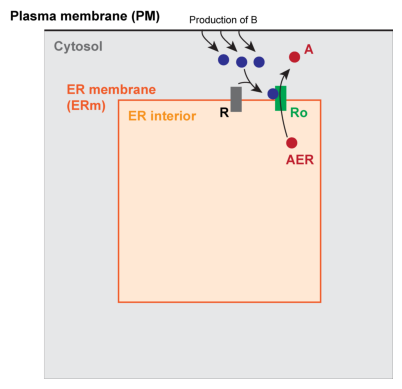

In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
img_A = mpimg.imread('example5-diagram.png')
plt.imshow(img_A)
plt.axis('off')

As specified in our [mathematical documentation](https://rangamanilabucsd.github.io/smart/docs/math.html), assuming diffusive transport, the PDE and boundary condition for each of these volumetric species takes the form:

$$
\partial_t u_i^m - \nabla \cdot ( D_i^m \nabla (u_i^m) ) - f_i^m(u_i^m) = 0 \qquad \text{ in } \Omega^m\\
D_i \nabla u_i^m \cdot n^m - R_i^{q} (u^m, u^n, v^q) = 0 \qquad \text{ on } \Gamma^{q}
$$

and the surface species take the form:

$$
\partial_t v_i^q - \nabla_S \cdot (D_i^q \nabla_S v ) - g_i^q ( u^m, u^n, v^q ) = 0 \qquad \text{ on } \Gamma^{q}\\
D_i \nabla v_i^q \cdot n^q = 0 \qquad \text{ on } \partial\Gamma^{q}
$$

Our reaction terms and boundary conditions are chosen according to the system described above. For the purposes of this simplified example we use linear mass action in all reaction terms. Explicitly writing out this system of PDEs, we have:

\begin{align}
    \partial_t u_B^{Cyto} - D_B^{Cyto} \nabla^2 u_B^{Cyto} + k_{2f} u_B^{Cyto} &= 0 \qquad \text{ in } \Omega^{Cyto}\\
    D_B^{Cyto} \nabla u_B^{Cyto} \cdot n^{Cyto} + j_1[t] &= 0 \qquad \text{ on } \Gamma^{PM} \nonumber\\
    D_B^{Cyto} \nabla u_B^{Cyto} \cdot n^{Cyto} + k_{3f} v_R^{ERm} u_B^{Cyto} - k_{3r} v_{Ro}^{ERm} &= 0 \qquad \text{ on } \Gamma^{ERm} \nonumber\\
    \nonumber \\
    \partial_t u_A^{Cyto} - D_A^{Cyto} \nabla^2 u_A^{Cyto} &= 0 \qquad \text{ in } \Omega^{Cyto}\\
    D_A^{Cyto} \nabla u_A^{Cyto} \cdot n^{Cyto} &= 0 \qquad \text{ on } \Gamma^{PM} \nonumber\\
    D_A^{Cyto} \nabla u_A^{Cyto} \cdot n^{Cyto} - k_{4,Vmax} v_{Ro}^{ERm} (u_{AER}^{ER} - u_A^{Cyto}) &= 0 \qquad \text{ on } \Gamma^{ERm} \nonumber\\
    \nonumber \\
    \partial_t u_{AER}^{ER} - D_{AER}^{ER} \nabla^2 u_{AER}^{ER} &= 0 \qquad \text{ in } \Omega^{ER}\\
    D_{AER}^{ER} \nabla u_{AER}^{ER} \cdot n^{ER} + k_{4,Vmax} v_{Ro}^{ERm} (u_{AER}^{ER} - u_A^{Cyto}) &= 0 \qquad \text{ on } \Gamma^{ERm} \nonumber\\
    \nonumber \\
    \partial_t v_{R}^{ERm} - D_{R}^{ERm} \nabla^2 v_{R}^{ERm} - 
    k_{3f} v_R^{ERm} u_B^{Cyto} + k_{3r} v_{Ro}^{ERm}  &= 0 \qquad \text{ on } \Gamma^{ERm}\\
    \nonumber \\
    \partial_t v_{Ro}^{ERm} - D_{Ro}^{ERm} \nabla^2 v_{Ro}^{ERm} +
    k_{3f} v_R^{ERm} u_B^{Cyto} - k_{3r} v_{Ro}^{ERm} &= 0 \qquad \text{ on } \Gamma^{ERm}\\
\end{align}

## Code imports and initialization

In [2]:
import logging

import dolfin as d
import sympy as sym
import numpy as np
import pathlib
import gmsh  # must be imported before pyvista if dolfin is imported first

from smart import config, mesh, model, mesh_tools, visualization
from smart.model_assembly import (
    Compartment,
    Parameter,
    Reaction,
    Species,
    SpeciesContainer,
    ParameterContainer,
    CompartmentContainer,
    ReactionContainer,
)
from smart.units import unit

We will set the logging level to `INFO`. This will display some output during the simulation. If you want to get even more output you could set the logging level to `DEBUG`.

In [3]:
logger = logging.getLogger("smart")
logger.setLevel(logging.INFO)

Futhermore, you could also save the logs to a file by attaching a file handler to the logger as follows.

```
file_handler = logging.FileHandler("filename.log")
file_handler.setFormatter(logging.Formatter(smart.config.base_format))
logger.addHandler(file_handler)
```

First, we define the various units for the inputs

In [4]:
# Aliases - base units
uM = unit.uM
um = unit.um
molecule = unit.molecule
sec = unit.sec
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = molecule / (um**2 * sec)
vol_unit = uM
surf_unit = molecule / um**2

## Generate model
Next we generate the model described in the equations above.

### Compartments
As described above, the three compartments are the cytosol ("Cyto"), the plasma membrane ("PM"), the ER membrane ("ERm"), and the ER interior volume ("ER").

Note that, as shown, we can also specify nonadjacency for compartments; this is not strictly necessary, but will generally speed up the simulations.

In [5]:
Cyto = Compartment("Cyto", 3, um, 1)
PM = Compartment("PM", 2, um, 10)
ER = Compartment("ER", 3, um, 2)
ERm = Compartment("ERm", 2, um, 12)
PM.specify_nonadjacency(['ERm', 'ER'])
ERm.specify_nonadjacency(['PM'])

Initialize a compartment container and add the 4 compartments to it.

In [6]:
cc = CompartmentContainer()
cc.add([ERm, ER, PM, Cyto])

### Species
In this case, we have 5 species across 3 different compartments. We define each in turn:

In [7]:
A = Species("A", 0.01, vol_unit, 1.0, D_unit, "Cyto")
B = Species("B", 0.0, vol_unit, 1.0, D_unit, "Cyto")
AER = Species("AER", 200.0, vol_unit, 5.0, D_unit, "ER")
# Create an algebraic expression to define the initial condition of R
Rinit = "(sin(40*y) + cos(40*z) + sin(40*x) + 3) * (y-x)**2"
R1 = Species("R1", Rinit, surf_unit, 0.02, D_unit, "ERm")
R1o = Species("R1o", 0.0, surf_unit, 0.02, D_unit, "ERm")

Create species container and add the 5 species objects to it.

In [8]:
sc = SpeciesContainer()
sc.add([R1o, R1, AER, B, A])

###  Parameters and Reactions

Parameters and reactions are generally defined together, although the order does not strictly matter. We define them in turn as follows:

In [9]:
# Degradation of B in the cytosol
k2f = Parameter("k2f", 10, 1 / sec)
r2 = Reaction(
    "r2", ["B"], [], param_map={"on": "k2f"}, reaction_type="mass_action_forward"
)

# Activating receptors on ERm with B
k3f = Parameter("k3f", 100, 1 / (uM * sec))
k3r = Parameter("k3r", 100, 1 / sec)
r3 = Reaction("r3", ["B", "R1"], ["R1o"], {"on": "k3f", "off": "k3r"})
# Release of A from ERm to cytosol
k4Vmax = Parameter("k4Vmax", 2000, 1 / (uM * sec))
r4 = Reaction(
    "r4",
    ["AER"],
    ["A"],
    param_map={"Vmax": "k4Vmax"},
    species_map={"R1o": "R1o", "uER": "AER", "u": "A"},
    eqn_f_str="Vmax*R1o*(uER-u)",
)

We define one additional reaction as the time-dependent production of species B at the plasma membrane. In this case, we define a pulse-type function as the derivative of an arctan function. Note that this is useful because we can provide an expression to use for pre-integration.

$$
j_{int}[t] = V_{max} \arctan\left({m (t - t_0)}\right)\\
j_1[t] = \int{j_{int}[t]}dt = \frac{m V_{max}}{1 + m^2 (t-t_0)^2}
$$

In [10]:
Vmax, t0, m = 500, 0.1, 200
t = sym.symbols("t")
pulseI = Vmax * sym.atan(m * (t - t0))
pulse = sym.diff(pulseI, t)
j1pulse = Parameter.from_expression(
    "j1pulse", pulse, flux_unit, use_preintegration=True, preint_sym_expr=pulseI
)
r1 = Reaction(
    "r1",
    [],
    ["B"],
    param_map={"J": "j1pulse"},
    eqn_f_str="J",
    explicit_restriction_to_domain="PM",
)





 2023-07-05 12:28:40,730 smart.model_assembly - WARNING - Warning! Pre-integrating parameter j1pulse. Make sure that expressions j1pulse appears in have no other time-dependent variables. (model_assembly.py:660) 








 2023-07-05 12:28:40,731 smart.model_assembly - WARNING - Warning! Pre-integrating parameter j1pulse. Make sure that expressions j1pulse appears in have no other time-dependent variables. (model_assembly.py:660) 






We can plot the time-dependent input by converting the sympy expression to a numpy function using lambdify.

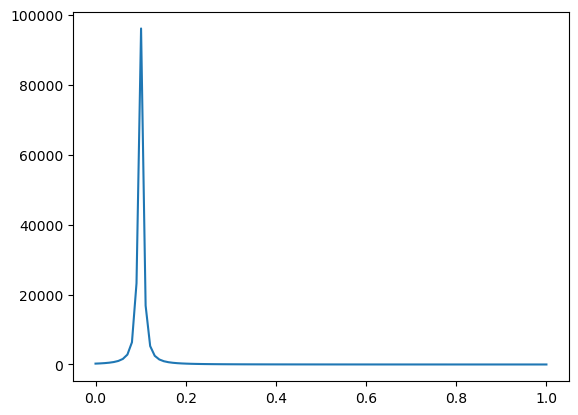

In [11]:
from sympy.utilities.lambdify import lambdify
pulse_func = lambdify(t, pulse, 'numpy')  # returns a numpy-ready function
tArray = np.linspace(0, 1, 100)
pulse_vals = pulse_func(tArray)
plt.plot(tArray, pulse_vals)

Note that we can also create a time-dependent parameter by reading data from a csv file. This is illustrated below, introducing a new parameter, "j1pulse_fromfile", which we do not use in the full model in this case. It could be used in the model by simply defining it as "j1pulse" to overwrite the parameter previously defined from an expression.

2023-07-05 12:28:43,199 smart.model_assembly - INFO - Loading in data for parameter j1pulse (model_assembly.py:547) 
2023-07-05 12:28:43,199 smart.model_assembly - INFO - Time-dependent parameter j1pulse loaded from file. (model_assembly.py:579) 


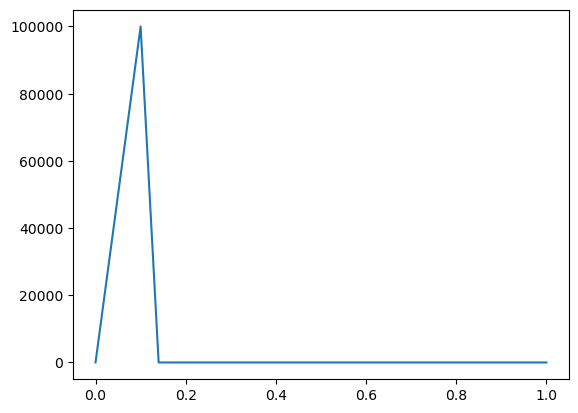

In [12]:
j1pulse_fromfile = Parameter.from_file("j1pulse", "sample_input.csv", flux_unit)
tArray = j1pulse_fromfile.sampling_data[:, 0]
pulse_vals = j1pulse_fromfile.sampling_data[:, 1]
plt.plot(tArray, pulse_vals)

Create containers for parameters and reactions and add all the parameters and reaction objects to them.

In [13]:
pc = ParameterContainer()
pc.add([k4Vmax, k3r, k3f, k2f, j1pulse])

rc = ReactionContainer()
rc.add([r1, r2, r3, r4])

## Create/load in mesh

In SMART we have different levels of meshes:
- Parent mesh: contains the entire geometry of the problem, including all surfaces and volumes
- Child meshes: submeshes (sections of the parent mesh) associated with individual compartments. Here, the child meshes are:
    - Cyto: the portion of the outer cube outside of the inner cube, defined by `cell_markers = 1`
    - ER: the inside portion of the inner cube, defined by `cell_markers = 2`
    - PM: surface mesh where x=0, defined by `facet_markers = 10`
    - ERm: surface mesh corresponding to all faces of the inner cube, defined by `facet_markers = 12`

Here we create a UnitCube mesh as the Parent mesh, defined by

$$
\Omega = [0, 1] \times [0, 1] \times [0, 1] \subset \mathbb{R}^3
$$

and we display a cut cross-section using pyvista.

/usr/lib/python3/dist-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


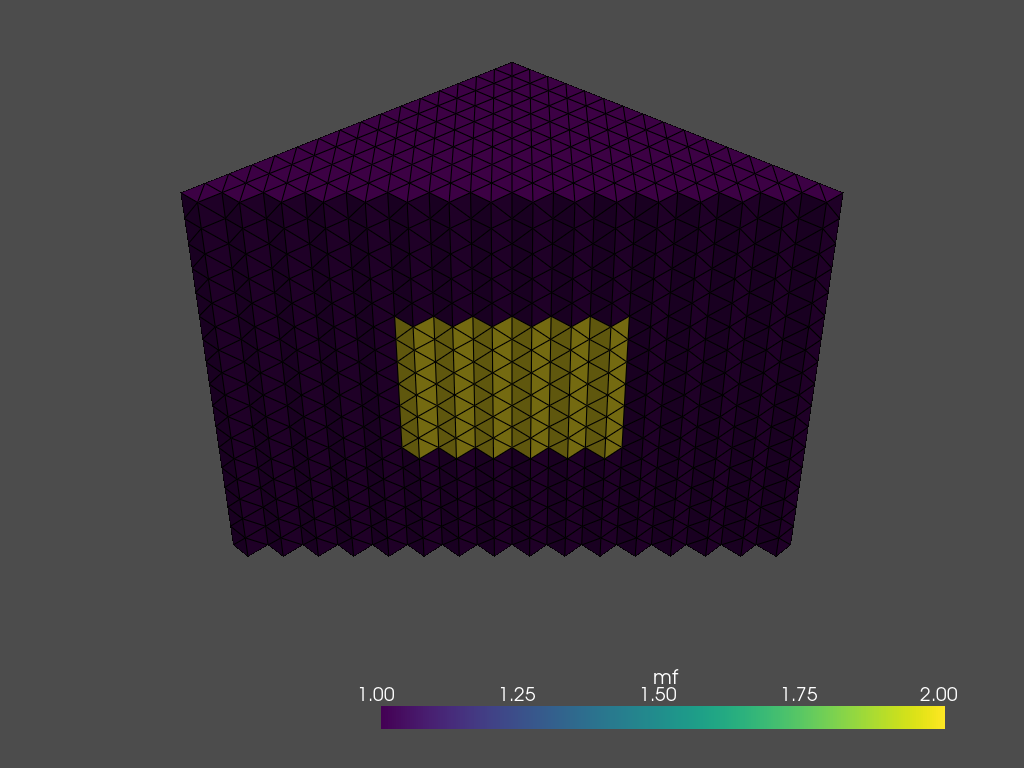

In [25]:
domain, facet_markers, cell_markers = mesh_tools.create_cubes()
visualization.plot_dolfin_mesh(domain, cell_markers, clip_plane=(1,
                               1, 0), clip_origin=(0.5, 0.5, 0.5))


By default, `smart.mesh_tools.create_cubes` marks all faces of the outer cube as "10", our marker value associated with PM. Here, since we are only treating the x=0 face as PM, we alter the facet markers on all other faces, setting them equal to zero. They are then treated as no-flux boundaries not belonging to a designated surface compartment. The resultant mesh with the new facet and volume markers is displayed below.

In [ ]:
for face in d.faces(domain):
    if face.midpoint().x() > d.DOLFIN_EPS and facet_markers[face] == 10:
        facet_markers[face] = 0
img_mesh = mpimg.imread('example5-mesh.png')
plt.imshow(img_mesh)
plt.axis('off')

We now save the mesh as an h5 file and then read it into SMART as a `ParentMesh` object. 

In [ ]:
mesh_folder = pathlib.Path("mesh")
mesh_folder.mkdir(exist_ok=True)
mesh_path = mesh_folder / "DemoCuboidsMesh.h5"
mesh_tools.write_mesh(
    domain, facet_markers, cell_markers, filename=mesh_path
)
parent_mesh = mesh.ParentMesh(
    mesh_filename=str(mesh_path),
    mesh_filetype="hdf5",
    name="parent_mesh",
)

## Model and solver initialization

Now we are ready to set up the model. First we load the default configurations and set some configurations for the current solver.

In [ ]:
conf = config.Config()
conf.solver.update(
    {
        "final_t": 1,
        "initial_dt": 0.01,
        "time_precision": 6,
        "print_assembly": False,
    }
)

We create a model using the different containers and the parent mesh. For later reference, we save the model information as a pickle file. 

In [ ]:
model_cur = model.Model(pc, sc, cc, rc, conf, parent_mesh)
model_cur.to_pickle('model_cur.pkl')

Note that we could later load the model information from the pickle file using the line:
```Python
model_cur = model.from_pickle(model_cur.pkl)
```

Next we need to initialize the model and solver.

In [ ]:
model_cur.initialize()

## Solving system and storing data

We create some XDMF files where we will store the output 

In [ ]:
# Write initial condition(s) to file
results = dict()
result_folder = pathlib.Path("results")
result_folder.mkdir(exist_ok=True)
for species_name, species in model_cur.sc.items:
    results[species_name] = d.XDMFFile(
        model_cur.mpi_comm_world, str(result_folder / f"{species_name}.xdmf")
    )
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)

We now run the the solver and store the data at each time point to the initialized files. We also integrate A over the cytosolic volume at each time step to monitor the elevation in A over time and we display the concentration of A in the cytosol at t = 0.2 s.

In [ ]:
# Set loglevel to warning in order not to pollute notebook output
logger.setLevel(logging.WARNING)

avg_A = [A.initial_condition]
# define integration measure and total volume for computing average A at each time point
dx = d.Measure("dx", domain=model_cur.cc['Cyto'].dolfin_mesh)
volume = d.assemble(1.0*dx)
# Solve
displayed = False
while model_cur.t < model_cur.final_t:
    # Solve the system
    model_cur.monolithic_solve()
    # Save results for post processing
    for species_name, species in model_cur.sc.items:
        results[species_name].write(model_cur.sc[species_name].u["u"], model_cur.t)
    # compute average A concentration at each time step
    int_val = d.assemble(model_cur.sc['A'].u['u']*dx)
    avg_A.append(int_val / volume)
    if model_cur.t >= 0.2 and not displayed:
        visualization.plot(model_cur.sc['A'].u['u'],
                           clip_plane=(1, 1, 0), clip_origin=(0.5, 0.5, 0.5))
        displayed = True


Finally, we plot the average concentration of A over time.

In [ ]:
plt.plot(model_cur.tvec, avg_A)
plt.xlabel('Time (s)')
plt.ylabel('Cytosolic concentration of A (μM)')

We also compare the AUC for A with previous numerical simulations (regression test).

In [ ]:
tvec = np.zeros(len(model_cur.tvec))
for i in range(len(model_cur.tvec)):
    tvec[i] = float(model_cur.tvec[i])
auc_cur = np.trapz(np.array(avg_A), tvec)
auc_compare = 4.579168566147441
percent_error = 100*np.abs(auc_cur - auc_compare)/auc_compare
assert percent_error < .01,\
    f"Failed regression test: Example 5 results deviate {percent_error:.3f}% from the previous numerical solution"